## Training Models with AWS SageMaker

SageMaker is a managed service to train and deploy ML models. This tutorial is a quickstart guide to train models on SageMaker with FARM. It walks through on how to train a model for the Document Classification task.

### Prerequisites
* AWS IAM Role with access to SageMaker and S3.
* A directory containing the training script(more details in the next section) that you want to run and a requirements.txt file for the dependencies(including FARM). You can find examples at https://github.com/deepset-ai/FARM/tree/master/examples.
* (optional) Cleaned/processed training data uploaded to a S3 bucket. If no train/dev data paths are supplied, the sample public datasets provided by FARM are used. 

### Train Script
Any of the FARM examples can be used for training with SageMaker with slight adjustments. The config/hyperparameters are passed as command line arguments when loading the train script. The train script can parse the arguments and set the parameters accordingly.

For this tutorial, there is a directory `source` at the same dir level of this notebook. It contains `document_classification.py` and a `requirements.txt` file.

In [1]:
from sagemaker.pytorch.estimator import PyTorch

In [2]:
role = "arn:aws:iam::xxxxxxxxxxxx:role/service-role/AmazonSageMaker-ExecutionRole-20191204Txxxxxx"

### Hyperparameters
Hyperparameters are passed to the Estimator(next step) and they are made available to the train script during training as a JSON file located at `/opt/ml/input/config/hyperparameters.json`.

In [3]:
hyperparameters = {
    "batch_size": 4,
    "n_epochs": 2,
    "max_seq_len": 32,
    "evaluate_every": 200,
    "base_lm_model": "bert-base-german-cased",
    
    # If no train/dev data paths are supplied, the sample public datasets provided by FARM are used for training
    # "train_filename": "<file-name>",
    # "dev_filename": "<file-name>",
    # "data_dir": "/opt/ml/input/data/train/",
}

### Estimator

`Estimator` is a high level abstraction for handling the training task on SageMaker. `PyTorch` Estimator builds a container with a specific version of PyTorch, install dependencies as supplied in the `source_dir`, and executes the training script as specified by `entry_point`. 

In [6]:
estimator = PyTorch(
    base_job_name="doc-classification-train-tutorial",
    entry_point="doc_classification.py",
    source_dir="source",  # the dir contains the train script and a requirements.txt file
    framework_version="1.3.1", # PyTorch version
    train_instance_count=1,
    role=role,  # IAM role to assume for execution
    hyperparameters=hyperparameters,
    
    # For testing locally first, set instance type as "local". To run on the cloud, set the  
    # param to an EC2 instance type, for example, "ml.p3.8xlarge"
    train_instance_type="ml.p3.2xlarge", 
    # output_path="s3://path-to-folder", # the S3 path where model is outputted 
)

### Start Training

The `fit()` method starts a training job. It takes the S3 path of the train data as an argument. `wait` argument specifies whether the call should wait for the training job to finish.

In [7]:
estimator.fit(
    # Set the S3 bucket for train data 
    # input={"train": "s3://<path-to-train-data>"}, 
    wait=False,
)

### Viewing the training job on the SageMaker Console

You can view the newly created training job in the SageMaker console in the "Training jobs" view, under the "Training" section. You can view the log stream and the resource utilization metrics in the console.
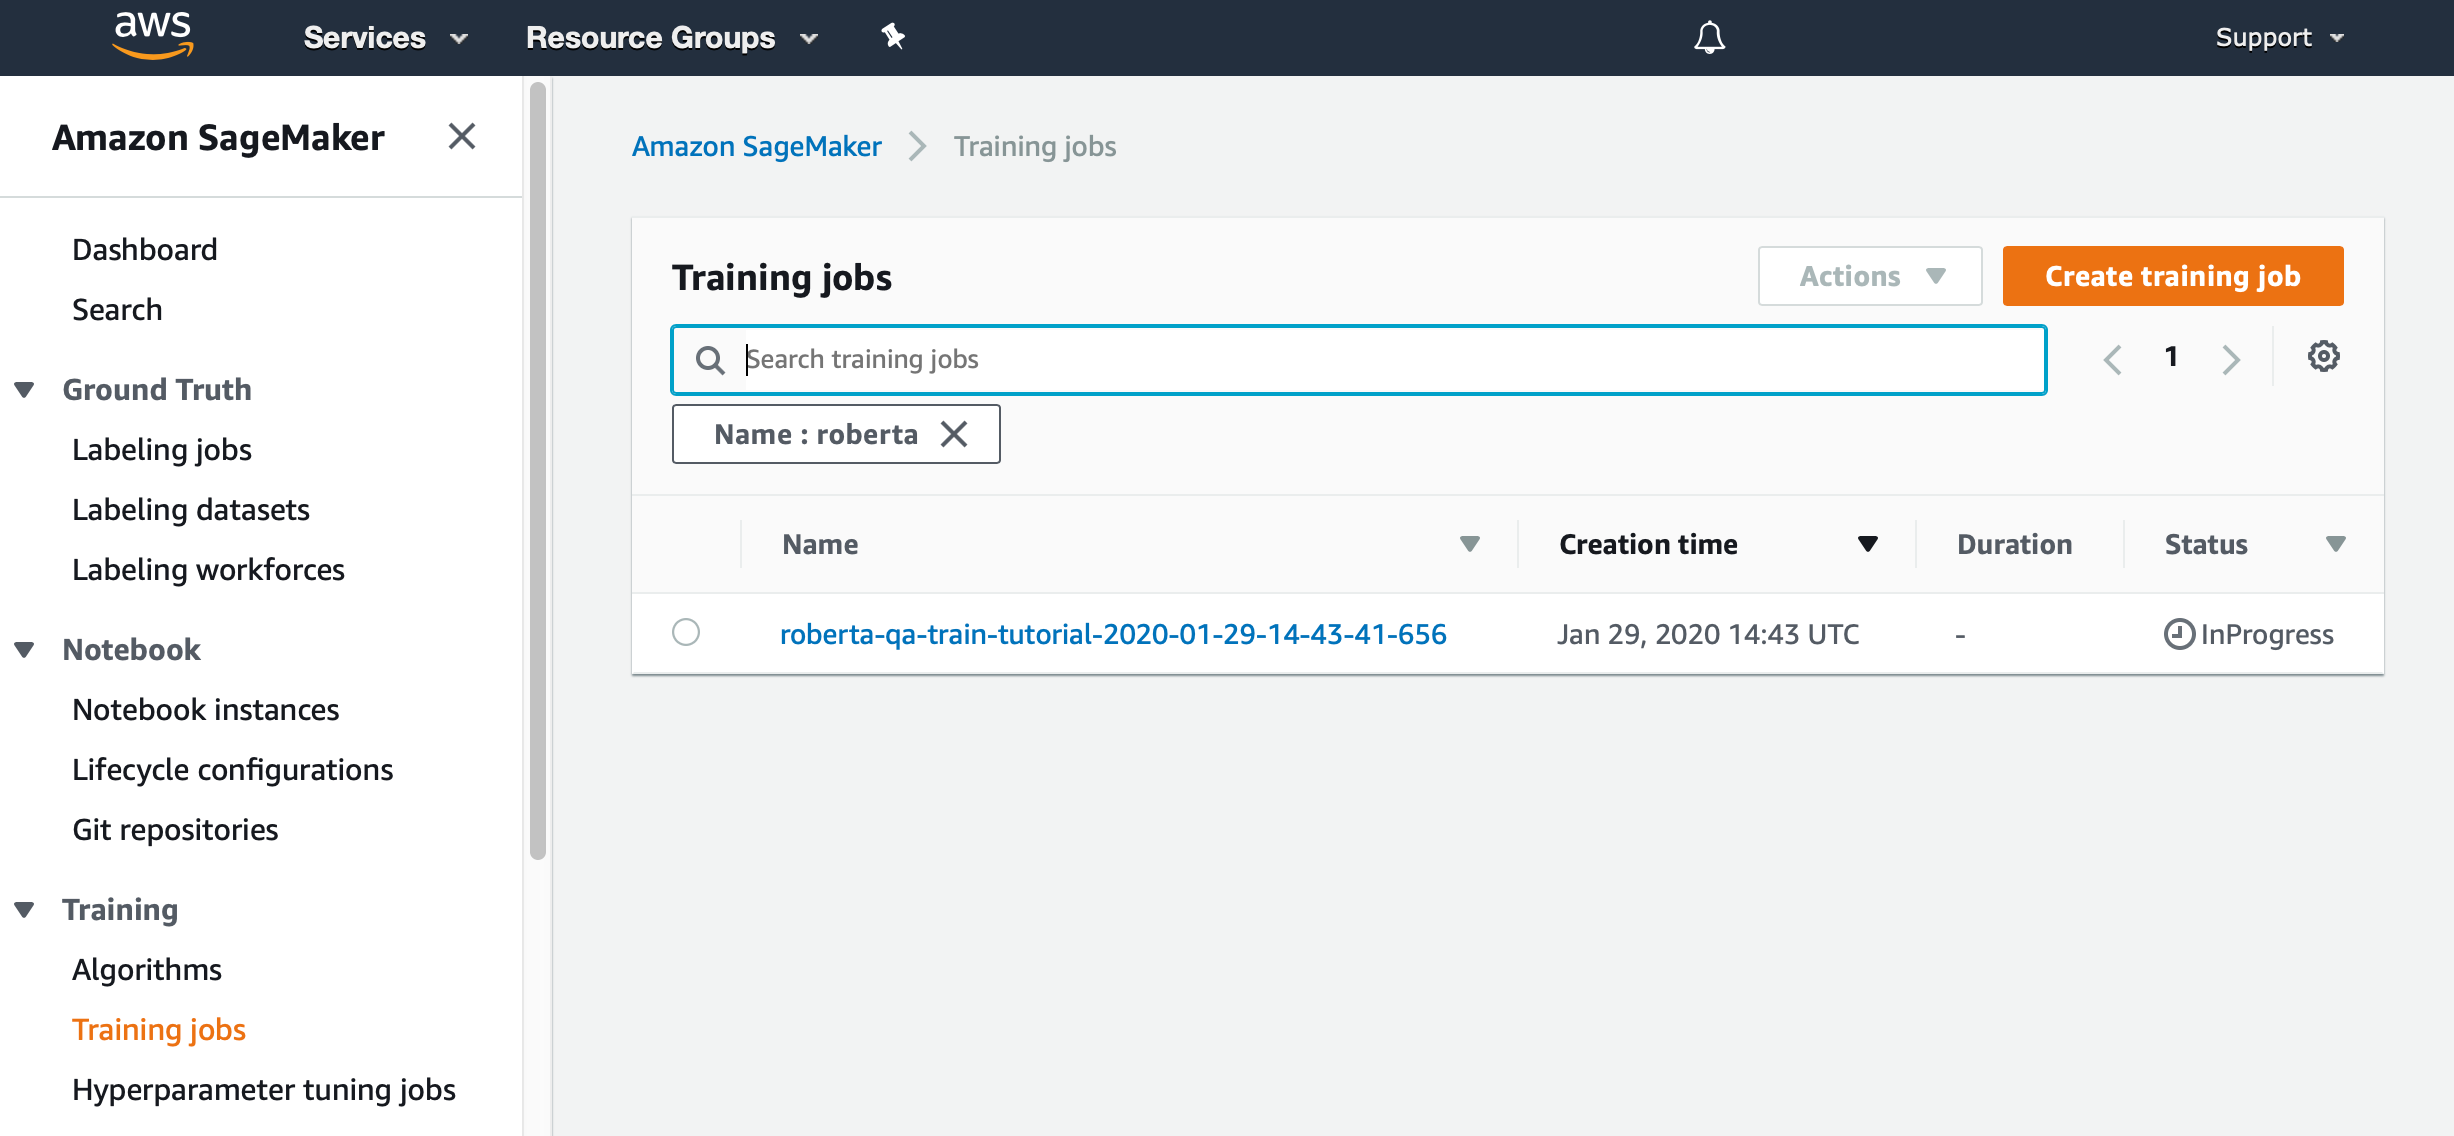

### Training with Spot Instances (optional)
SageMaker provides managed Spot Instances that provides significant cost savings as compared to on-demand instances. The `Trainer` in FARM has built-in checkpointing functionality that allows saves periodic checkpoint(state of the dataloaders, models, optimizers, and schedulers), so after an interruption, the training can be resumed from the previous state.